<a href="https://colab.research.google.com/github/mounsifelatouch/oibsip_taskno4/blob/master/EmailSpamDetectionWithMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oasis Infobyte Internship (15 October - 15 November, 2023)
## Data Science Internship
### <u>`Task 4`</u> : `EMAIL SPAM DETECTION WITH MACHINE LEARNING`
#### `MOUNSIF EL ATOUCH`

# `The main objective:`
In the context of email spam detection, the objective is to maximize the identification of positive cases (spam emails) while accepting a higher rate of false alarms (legitimate emails classified as spam). This prioritizes achieving high recall or sensitivity, as the primary goal is to minimize false negatives (spam emails incorrectly labeled as legitimate). The aim is to capture as many spam emails as possible, even if it means some legitimate emails are mistakenly flagged as spam.

In [1]:
# Needed packages
import pandas as pd                 # For data manipulation and analysis
import numpy as np                  # For numerical computations and handling arrays
import matplotlib.pyplot as plt     # For data visualization
import seaborn as sns               # For enhanced data visualization
from sklearn.model_selection import train_test_split      # For dataset splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
import string
import nltk

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from collections import Counter , defaultdict
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")                         # Disable warnings
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
def corpus(label):
    words=''
    for msg in data[data['category'] == label]['message']:
        msg = msg.lower()
        words+=msg + ''
    return words

def visualize(label):
    wordcloud = WordCloud(width=600, height=400).generate(corpus(label))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [3]:
stop_words = stopwords.words('english')+ ['u', 'im', 'c']
stemmer = nltk.SnowballStemmer('english')

def clean_text(text):
    '''Do lowercase, remove text in square brackets,links, punctuation
    and words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    ''' Remove stopwords '''
    text  = ' '.join(word for word in text.split() if word not in stop_words)
    ''' Stemming '''
    text  = ' '.join(stemmer.stem(word) for word in text.split())

    return text

In [4]:
! wget https://raw.githubusercontent.com/mounsifelatouch/oibsip_taskno4/master/spam.csv

--2023-10-29 15:35:51--  https://raw.githubusercontent.com/mounsifelatouch/oibsip_taskno4/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.06s   

2023-10-29 15:35:52 (8.63 MB/s) - ‘spam.csv’ saved [503663/503663]



In [5]:
# Load the dataset
data = pd.read_csv("/content/spam.csv", encoding='ISO-8859-1')

In [6]:
# Disply the first few rows of the dataset
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# Check dataset's shape
data.shape

''' The dataset comprises a total of 5572 records '''

' The dataset comprises a total of 5572 records '

In [8]:
# Drop unnecessary columns
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Rename columns for consistency and easier access
data.columns = ['category', 'message']

# Reset the index of the DataFrame
data.reset_index()

# Display the first few rows of the modified DataFrame
data.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Check for missong values
data.isnull().sum()

category    0
message     0
dtype: int64

In [10]:
# Check for duplicate
data.duplicated().sum()

403

# **`Exploratory Data Analysis`**


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### `Count of Ham and Spam messages`

In [12]:
''' An imbalanced data with an imbalance ratio approximately equal to 0.15
    imbalance ratio = count of minority class / count of majority class'''

print(data['category'].value_counts())

imbalance_ratio = data['category'].value_counts()[1]/ data['category'].value_counts()[0]
print(f"imbalance ration = {imbalance_ratio}")

ham     4825
spam     747
Name: category, dtype: int64
imbalance ration = 0.15481865284974095


In [13]:
# using describe()
data.groupby('category').describe()

message                                                            \
           count unique                                                top   
category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
category       
ham        30  
spam        4

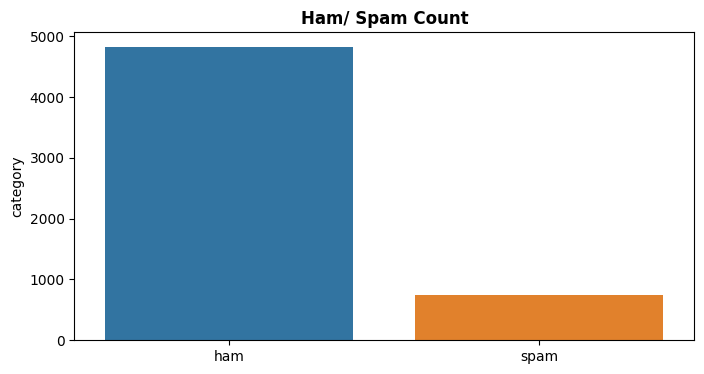

In [14]:
plt.figure(figsize=(8,4))

x = data['category'].value_counts().index
y = data['category'].value_counts()

plt.title('Ham/ Spam Count', fontweight='bold')
sns.barplot(x=x, y=y)
plt.show()

### `Ham and Spam messages ratios`

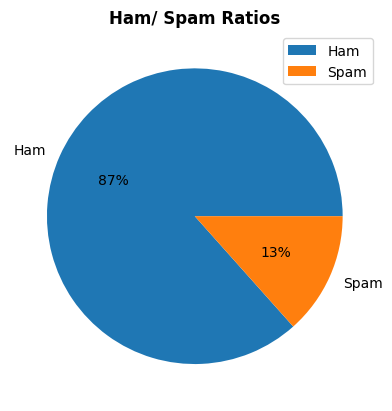

In [15]:
x = data['category'].value_counts()
label = ['Ham','Spam']

plt.title('Ham/ Spam Ratios', fontweight='bold')
plt.pie(x=x, labels=label, autopct='%.0f%%')
plt.legend()

plt.show()

### `Message length`

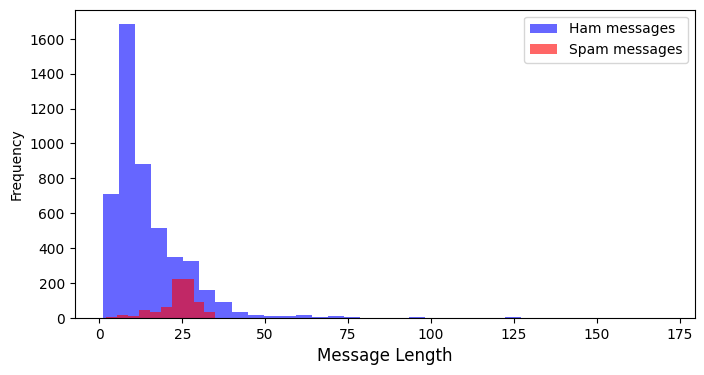

In [16]:
temp = data.copy()
temp['word_length'] = temp['message'].apply(lambda x:len(x.split()))

plt.figure(figsize=(8, 4))
temp[temp.category=='ham'].word_length.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
temp[temp.category == 'spam'].word_length.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Length", fontsize = 12)
plt.show()

<u>`Comments`</u>
* The majority of messages exhibit a word count ranging from 2 to 75 words.
* Spam messages typically have a word count ranging from 5 to 35 words.
* The dataset predominantly consists of ham messages, indicating that ham is the most common type of message in the dataset.
* In comparison to ham messages, spam messages tend to be shorter in length.

### `Average messages lenght`

In [17]:
avg_sent_lenght = np.mean([len(s.split()) for s in data['message']])
print("Average messages' lenght = ", avg_sent_lenght)

Average messages' lenght =  15.494436468054559


### `Average word lenght in messages`

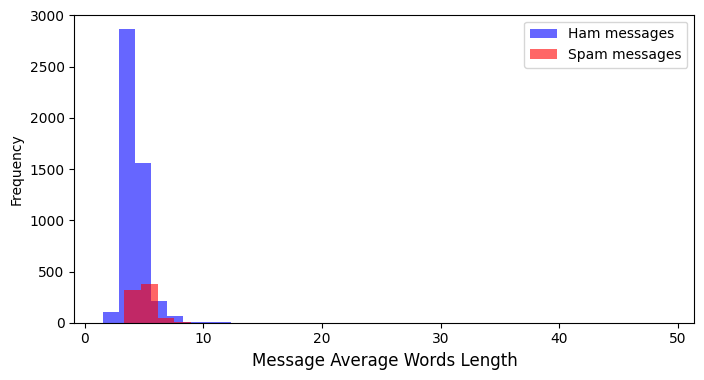

In [18]:
temp = data.copy()
temp['message_average_lenght'] = temp['message'].map(lambda x: np.mean([len(w) for w in str(x).split()]))

plt.figure(figsize=(8, 4))

temp[temp.category == 'ham'].message_average_lenght.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
temp[temp.category == 'spam'].message_average_lenght.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Average Words Length", fontsize = 12)
plt.show()

In average, spam messages tend to be shorter in length compared to ham messages.

# **`Data Preprocessing`**

In [19]:
data['message'] = data['message'].apply(clean_text)

### `Word Cloud`

Featured words in spam messages:


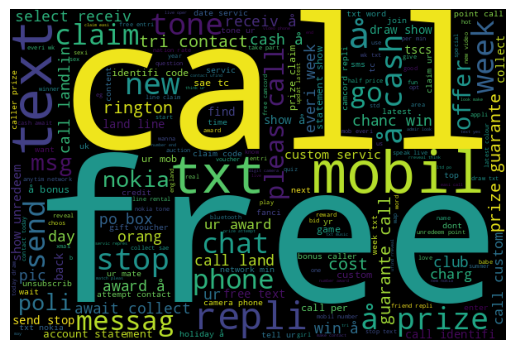

Featured words in non-spam messages:


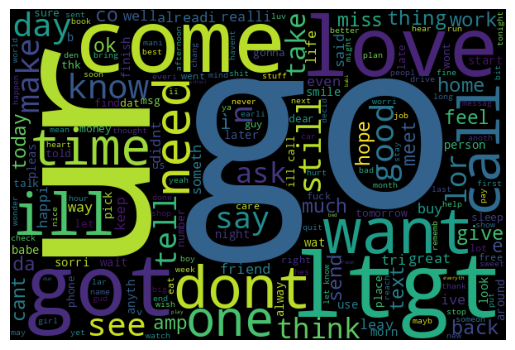

In [20]:
print("Featured words in spam messages:")
visualize('spam')

print("Featured words in non-spam messages:")
visualize('ham')

### `Get the most frequent words`

In [21]:
most_common_words = Counter(corpus('ham').split()).most_common(10)
print(most_common_words)

[('go', 361), ('get', 303), ('ur', 232), ('ltgt', 223), ('call', 218), ('come', 218), ('ill', 205), ('like', 203), ('dont', 185), ('know', 185)]


In [22]:
most_common_words = Counter(corpus('spam').split()).most_common(10)
print(most_common_words)

[('call', 295), ('å£', 263), ('free', 166), ('txt', 148), ('text', 133), ('mobil', 125), ('ur', 124), ('claim', 105), ('repli', 105), ('prize', 88)]


# **`Feature Extraction` & `Model Building`**

### `Feature Extraction`

In [23]:
# Convert 'ham' to 0 and 'spam' to 1 directly in the 'category' column
Encoder = LabelEncoder()
labels = Encoder.fit_transform(data['category'].map({'ham': 0, 'spam': 1}))

features = data['message']

In [24]:
''' Combine features and labels into a list of tuples, then create a DataFrame from the combined data '''

pd.DataFrame(list(zip(features, labels)), columns=['message', 'category'])

,message,category
0,go jurong point crazi avail bugi n great world...,0
1,ok lar joke wif oni,0
2,free entri wkli comp win fa cup final tkts may...,1
3,dun say earli hor alreadi say,0
4,nah dont think goe usf live around though,0
...,...,...
5567,time tri contact å£ pound prize claim easi cal...,1
5568,ì b go esplanad fr home,0
5569,piti mood soani suggest,0
5570,guy bitch act like id interest buy someth els ...,0


#### using `Count Vector`

In [25]:
# Initialize the Count Vectorizer
count_vectorizer = CountVectorizer(dtype=np.float32)

# Apply the vectorizer to the features noted X
XVec = count_vectorizer.fit_transform(features)

# Convert the result to a dense array (if needed)
XVec = XVec.toarray()

In [26]:
print(XVec[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XVec, labels, test_size=0.3, random_state=123)

In [28]:
# Split the existing X_test and y_test into X_test, X_val, y_test, y_val
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

### `Model Training & Evaluation`


We are facing a classification problem with a significant class imbalance, where the Spam class is much less frequent than the other classes. Merely relying on accuracy alone may not provide us with a comprehensive understanding of our model's performance.

We'll use the precision-recall curve to select a threshold for balancing precision and recall on an imbalanced dataset.

`Balanced Random Forest (BRF)` <br />

The[ Balanced Random Forest](https://imbalanced-ensemble.readthedocs.io/en/latest/api/ensemble/_autosummary/imbens.ensemble.BalancedRandomForestClassifier.html) (BRF) algorithm is a specialized algorithm created to tackle the challenges posed by imbalanced data. It aims to address the issue of imbalanced classes by employing specific techniques within its framework.


In [29]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(class_weight='balanced_subsample', random_state=123)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)

print(f"f1 score \t\t= {f1_score(y_test, y_pred):.2f}")
print(f"precision score \t= {precision_score(y_test, y_pred):.2f}")
print(f"recall score \t\t= {recall_score(y_test, y_pred):.2f}")

f1 score 		= 0.90
precision score 	= 0.92
recall score 		= 0.89


In [30]:
# Calculate predicted probabilities for the positive class using the Balanced Random Forest (BRF) model
y_scores = brf.predict_proba(X_test)[:, 1]

# Compute precision and recall values along with corresponding thresholds using the predicted probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the area under the precision-recall curve (AUC) for the BRF model
auc_score = auc(recall, precision)

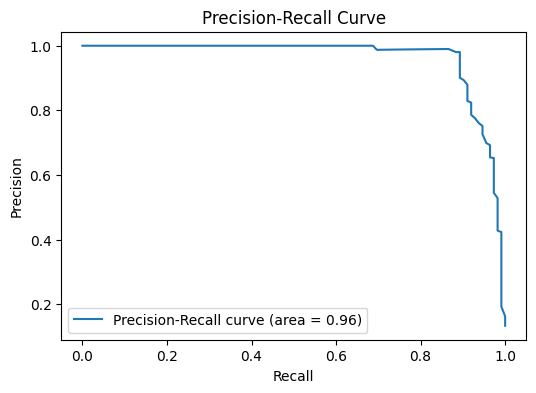

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

best threshold = 0.59


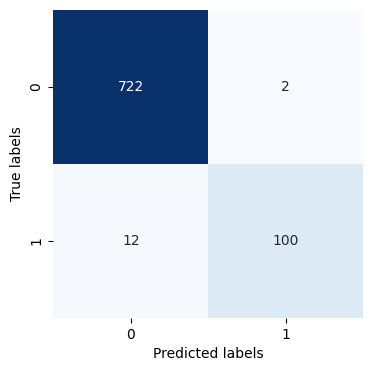

In [32]:
# Set a chosen threshold for classifying the predictions
f1_scores = [f1_score(y_test, (y_scores >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"best threshold = {best_threshold}")

# Classify the predictions based on the chosen threshold
y_pred_brf = np.where(y_scores >= best_threshold, 1, 0)

# Compute the confusion matrix using the true labels and the predicted labels
cm = confusion_matrix(y_test, y_pred_brf)

# Create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [33]:
# Create a new instance of BalancedRandomForestClassifier
brf_retrained = BalancedRandomForestClassifier(class_weight='balanced_subsample', random_state=123)

# Fit the retrained BalancedRandomForestClassifier on X_test and y_pred_brf
brf_retrained.fit(X_test, y_pred_brf)

# Make predictions
y_pred_val = brf.predict(X_val)

print(f"f1 score \t\t= {f1_score(y_val, y_pred_val):.2f}")
print(f"precision score \t= {precision_score(y_val, y_pred_val):.2f}")
print(f"recall score \t\t= {recall_score(y_val, y_pred_val):.2f}")

f1 score 		= 0.92
precision score 	= 0.95
recall score 		= 0.89


In [34]:
spam_messages = [
    "Congratulations! You've won a $1000 cash prize. Claim it now by replying 'WIN'.",
    "Urgent: Your account has been suspended. Click the link to verify your information.",
    "You've been selected for a free vacation! Call now to claim your prize.",
    "Limited Time Offer: Buy one, get one free! Visit our website for exclusive deals.",
    "Your mobile number has been chosen for a cash reward. Reply 'CLAIM' to proceed.",
    "You have a new voicemail. Dial *123# to listen now. Charges may apply.",
    "Exclusive deal! Get 50% off on your next purchase. Show this message at the store."
]

messages = []
predictions = []

for message in spam_messages:
    mail = count_vectorizer.transform([message])
    prediction = brf.predict(mail)
    messages.append(message)
    predictions.append("Spam" if prediction[0] == 1 else "Ham")

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Message': messages,
    'Prediction': predictions
})

df

,Message,Prediction
0,Congratulations! You've won a $1000 cash prize...,Spam
1,Urgent: Your account has been suspended. Click...,Spam
2,You've been selected for a free vacation! Call...,Spam
3,"Limited Time Offer: Buy one, get one free! Vis...",Spam
4,Your mobile number has been chosen for a cash ...,Spam
5,You have a new voicemail. Dial *123# to listen...,Ham
6,Exclusive deal! Get 50% off on your next purch...,Ham


## `Conclusion`

Given the imbalanced nature of the dataset, it is not uncommon for the model to make a few errors, particularly on the minority class (Spam).